In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import savefig

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
from pydoc import source_synopsis


In [2]:
sns.set_palette('crest')
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})


In [3]:
bank_df = pd.read_csv('../data/bank/bank-full.csv', sep=';')

In [4]:
# Find the categorical variables
print("data types of the features: \n", bank_df.dtypes)


data types of the features: 
 age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object


In [5]:
# Group age by percentages of 10
labels = [0] + [f'{i+10}' for i in range(10, 100, 10)]
bank_df['age_groups'] = pd.qcut(bank_df['age'], 10, labels=labels)
bank_df.age_groups = bank_df.age_groups.astype("int")
# print(df[['age', 'age_groups']])


In [6]:
bank_df.month = bank_df.month.replace(["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

bank_df.default = bank_df.default.replace(["yes", "no"], [1, 0])
bank_df.housing = bank_df.housing.replace(["yes", "no"], [1, 0])
bank_df.loan = bank_df.loan.replace(["yes", "no"], [1, 0])


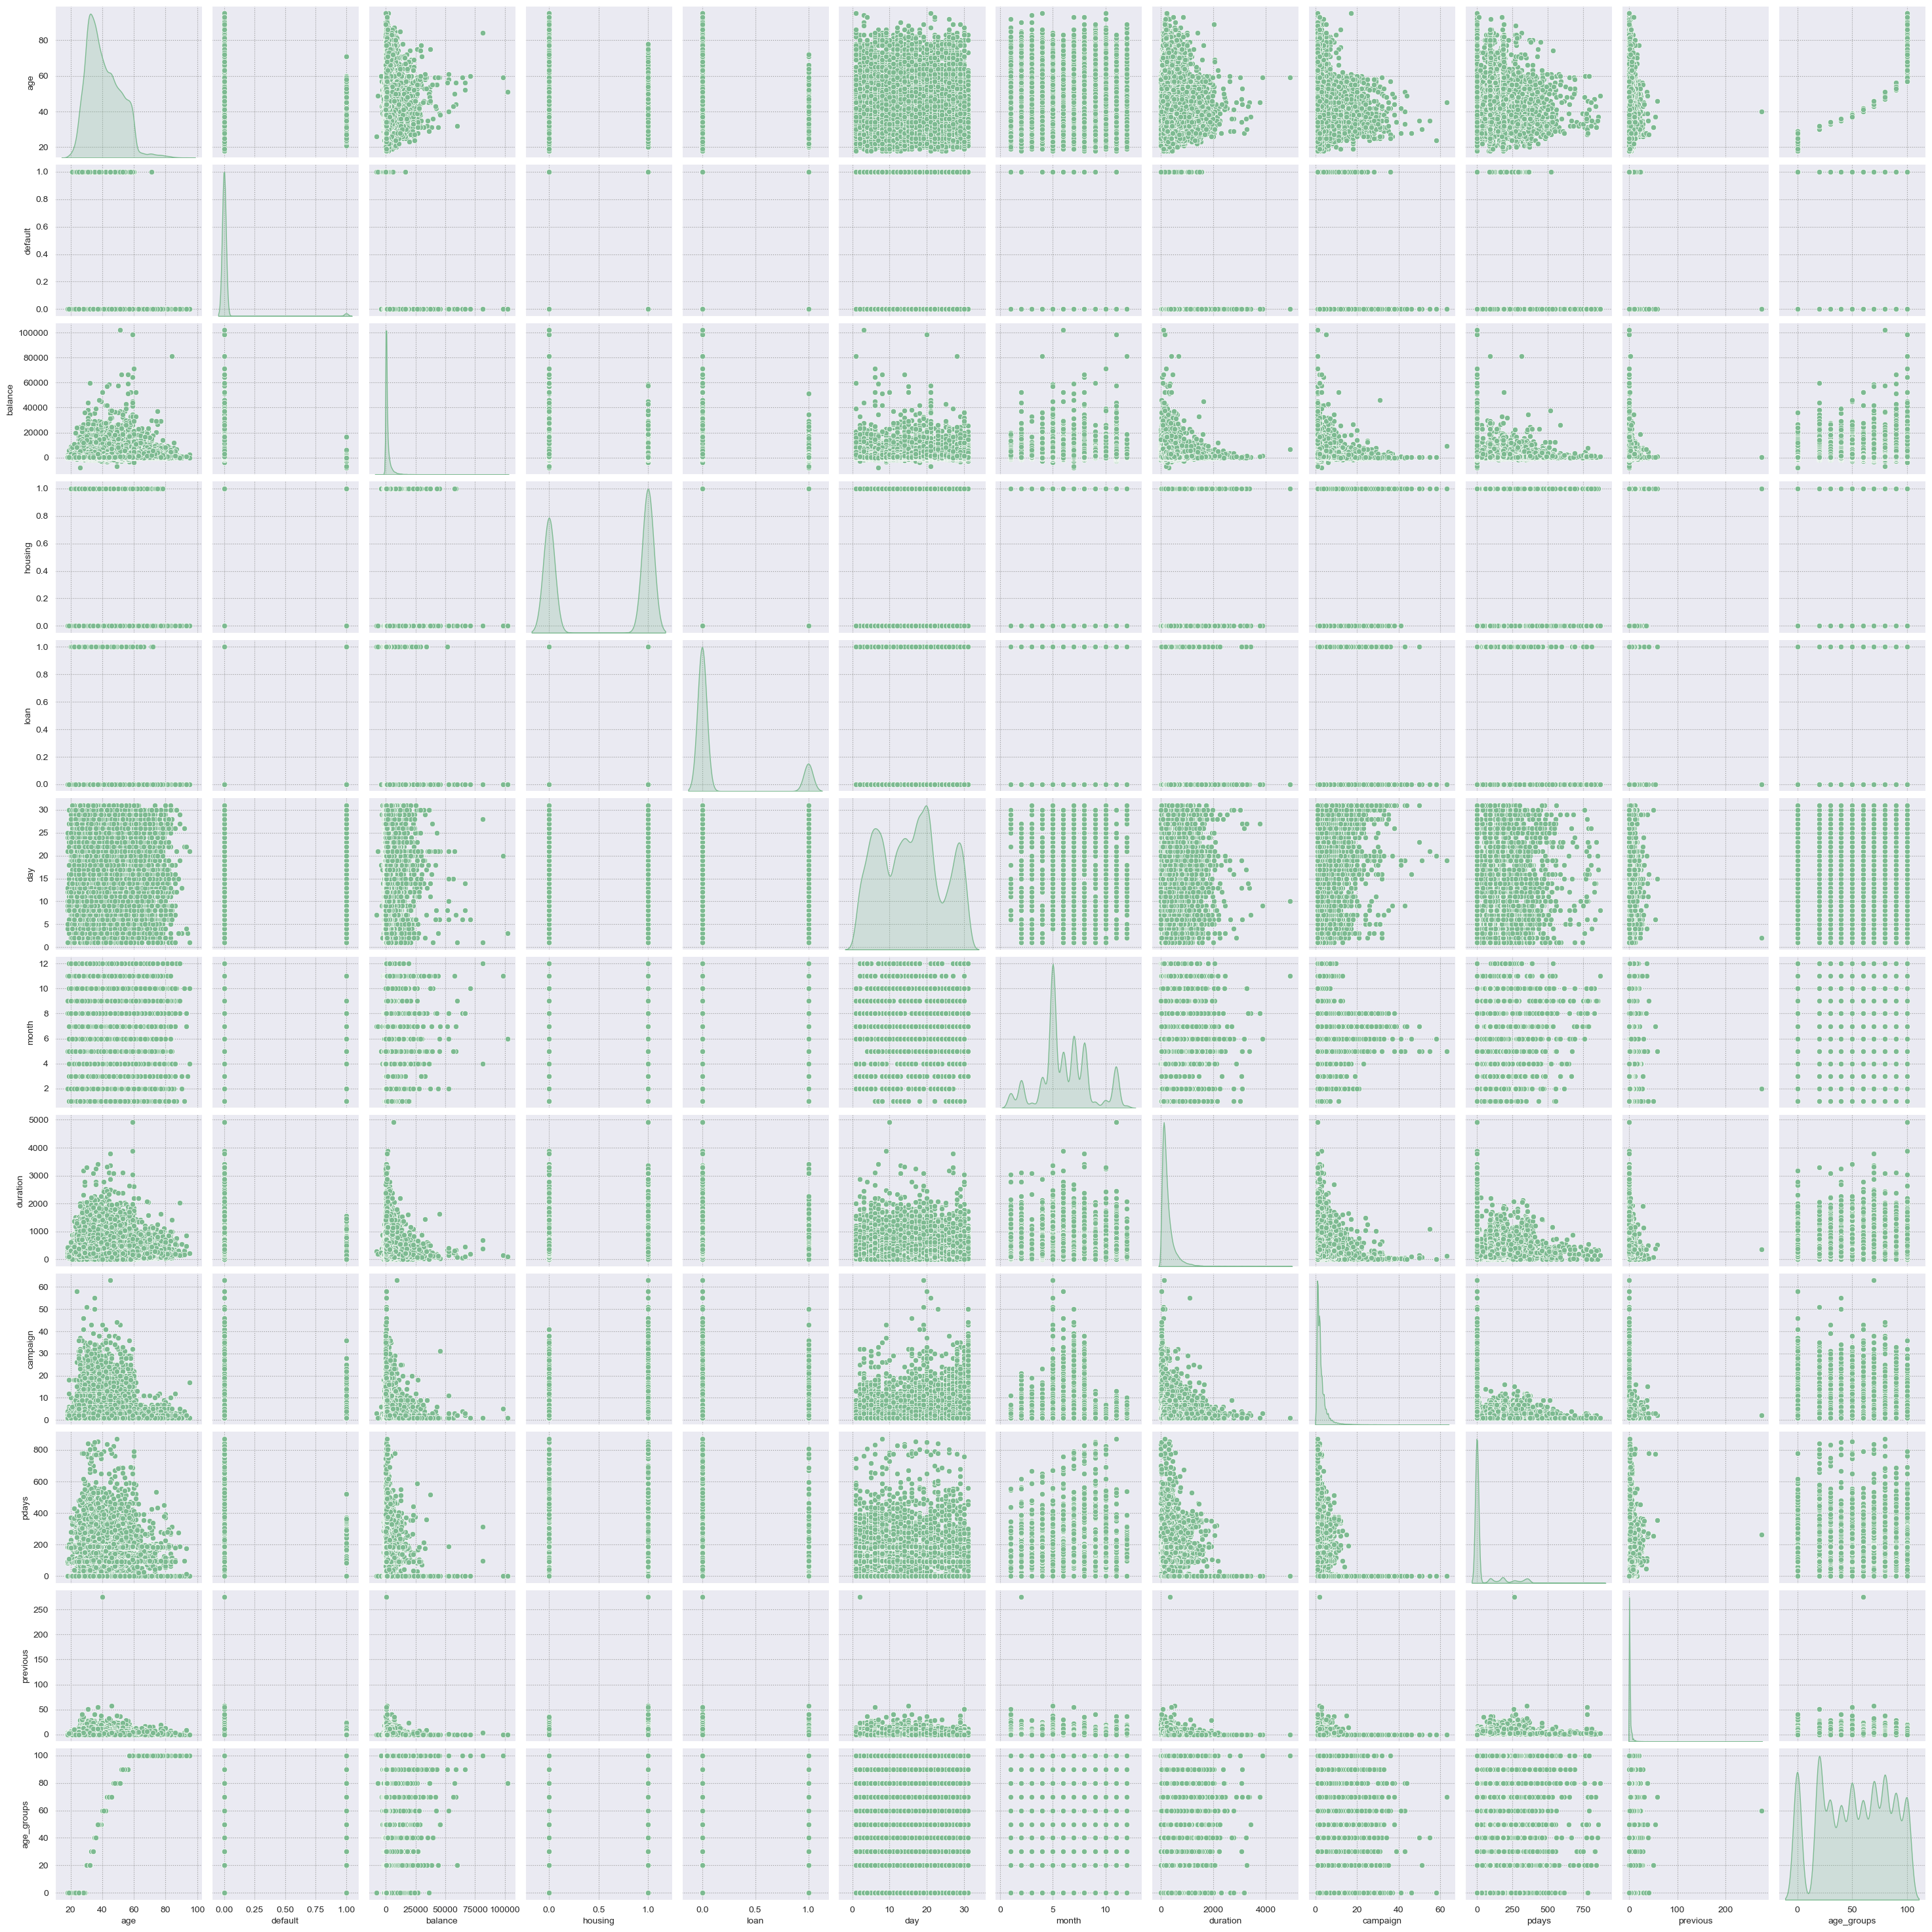

In [7]:
fig = sns.pairplot(bank_df, diag_kind='kde')
plt.show(fig)

fig.savefig('../graphs/joint_distribution.png', dpi=400)


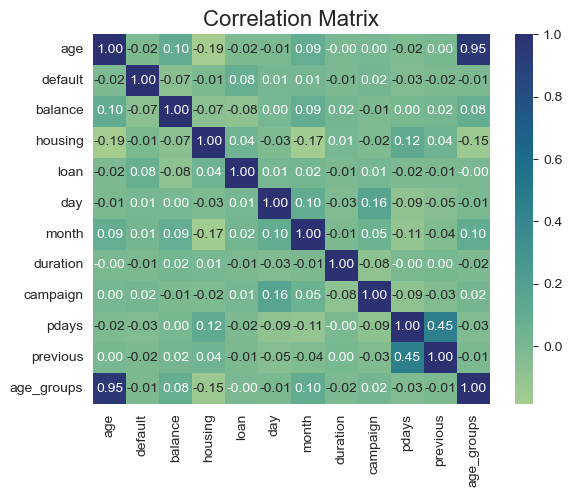

In [8]:
#### Check the Correlation Matrix of the Numerical Variables

numeric_bank_df = bank_df.select_dtypes(exclude="object")
# categorical_df = df.select_dtypes(include="object")

corr_numeric = numeric_bank_df.corr()


fig = sns.heatmap(corr_numeric, cbar=True, annot=True, fmt=".2f", cmap="crest")
plt.title("Correlation Matrix", fontsize=16,)
plt.show(fig) 

figure = fig.get_figure()
figure.savefig('../graphs/correlation_matrix.png', dpi=400)


In [9]:
cat_vars = ['job', 'marital', 'education', 'contact', 'poutcome']


bank_df_dummies = pd.get_dummies(bank_df, columns=cat_vars)

# print("check the column names: ", bank_df_dummies.columns.tolist())
# print("\n")
# print("total number of columns: ", len(bank_df_dummies.columns.tolist()))


In [10]:
# Since Deposit is the label so we can now prepare the training and test data for further analysis

## Turn yes/no in deposit to 1/0

# print(bank_df_dummies['y'].value_counts())


In [11]:
bank_df_dummies['y'] = bank_df_dummies['y'].map(
    {'yes': 1, 'no': 0})

# print(bank_df_dummies['y'].value_counts())


In [12]:
labels = bank_df_dummies[['y']]
# print("check labels: ", labels.head(3))


In [13]:
features = bank_df_dummies.drop(['y'], axis=1)


In [14]:
col_names_list = list(features.columns.values)
# print("features in a list: ", col_names_list)
# print("\n")
# print("number of features: ", len(col_names_list))


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.20, stratify=labels)

print("number of training samples: ", len(X_train))
print("number of test samples: ", len(y_test))


number of training samples:  36168
number of test samples:  9043


In [16]:
pipe_steps = [('scaler', StandardScaler()),
              ('decsT', DecisionTreeClassifier())]

check_params = {'decsT__criterion': ['gini', 'entropy'],
                'decsT__max_depth': np.arange(3, 15)}

pipeline = Pipeline(pipe_steps)
print(pipeline)


Pipeline(steps=[('scaler', StandardScaler()),
                ('decsT', DecisionTreeClassifier())])


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.883303 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.883303 to fit



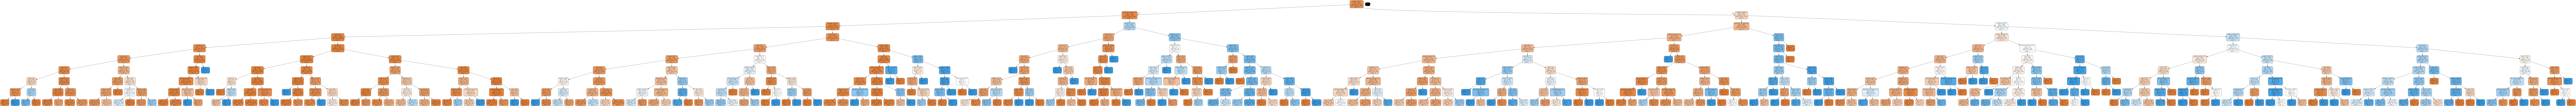

In [17]:

DecsTree = DecisionTreeClassifier(criterion='gini', max_depth=9)
DecsTree.fit(X_train, y_train)


dot_data = StringIO()

export_graphviz(DecsTree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names=col_names_list, class_names=['0', '1'])


graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

graph.write_png('../graphs/decision_tree_d9.png',)
# graph.set_size('"300, 180!"')
# graph.write_png('resized_tree.png')
Image(graph.create_png())


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.878448 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.878448 to fit



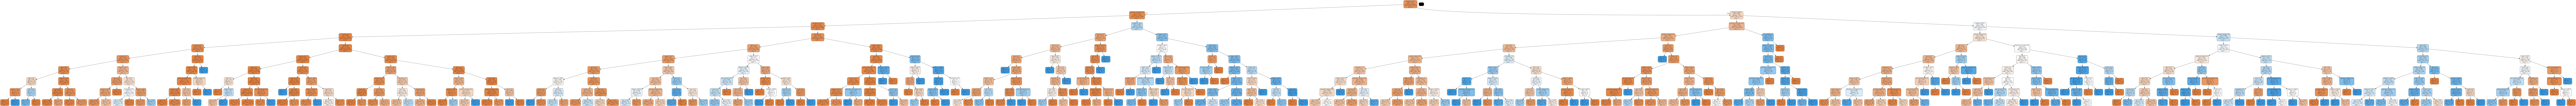

In [18]:
DecsTreeCheck = DecisionTreeClassifier(criterion='gini', max_depth=4)
DecsTree.fit(X_train, y_train)


dot_data = StringIO()

export_graphviz(DecsTree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names=col_names_list, class_names=['0', '1'])


graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

graph.write_png('../graphs/decision_tree_d4.png',)
Image(graph.create_png())


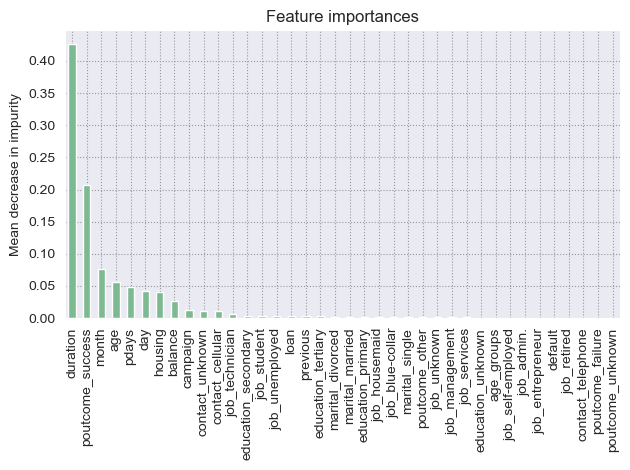

In [19]:
importances = DecsTree.feature_importances_
forest_importances = pd.Series(importances, index=DecsTree.feature_names_in_)
forest_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

figure = fig.get_figure()
figure.savefig('../graphs/feature_importance.png', dpi=400)

plt.show(fig)

In [32]:
# Group duration in bins containing percentages of 10
labels = [f'{i+0}% to {i+25}%' for i in range(0, 100, 25)]
bank_df['duration_percentiles'] = pd.qcut(
    bank_df['duration'], 4, labels=labels)
# print(bank_df[['duration', 'duration_percentiles']])

# Group duration by steps
durationBins = [1, 50, 100, 1000, 3000, 5000]
bank_df['duration_groups'] = pd.cut(bank_df['duration'], durationBins)
# print(bank_df[['duration', 'duration_groups']])


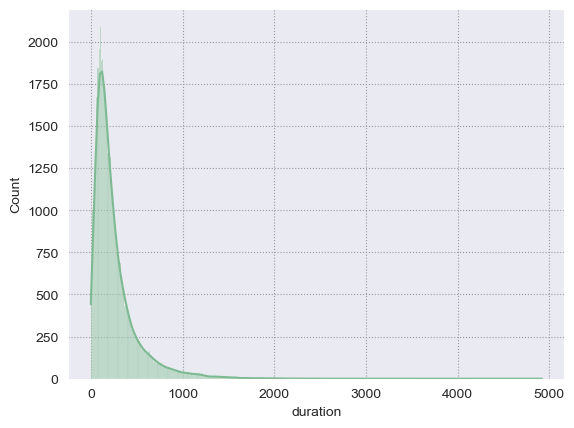

In [21]:
fig = sns.histplot(data=bank_df, x="duration", kde=True, palette='crest')
# sns.set_palette('crest')
plt.show(fig)


figure = fig.get_figure()
figure.savefig('../graphs/duration_distribution.png', dpi=400)

plt.show(fig)


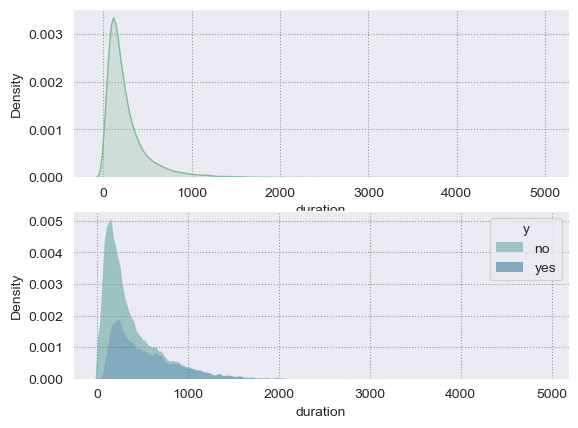

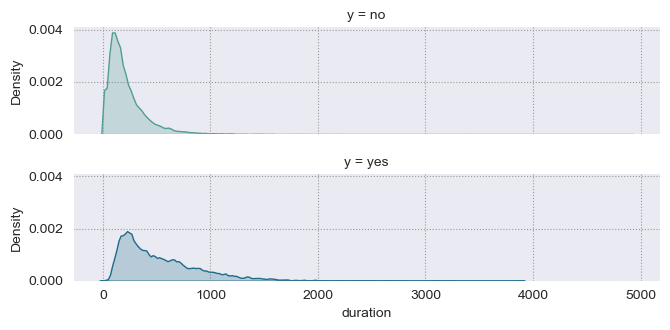

In [22]:
fig1, ax = plt.subplots(2, 1)
sns.kdeplot(data=bank_df, x="duration", fill=True, palette='crest', ax=ax[0])
sns.kdeplot(data=bank_df, x="duration", hue='y', bw_adjust=.2, multiple='stack', fill=True,
            common_norm=False, palette="crest", alpha=.5, linewidth=0, ax=ax[1])
plt.show(fig1)

figure = fig1.get_figure()
figure.savefig('../graphs/duration_distribution_stacked.png', dpi=400)

ordered_y = bank_df.y.value_counts().index
g = sns.FacetGrid(bank_df, row="y", row_order=ordered_y,
                  height=1.7, aspect=4, hue='y', palette="crest")
g.map(sns.kdeplot, "duration", fill=True, bw_adjust=.2)
plt.show(g)

g.savefig('../graphs/duration_distribution_per_y_split.png', dpi=400)


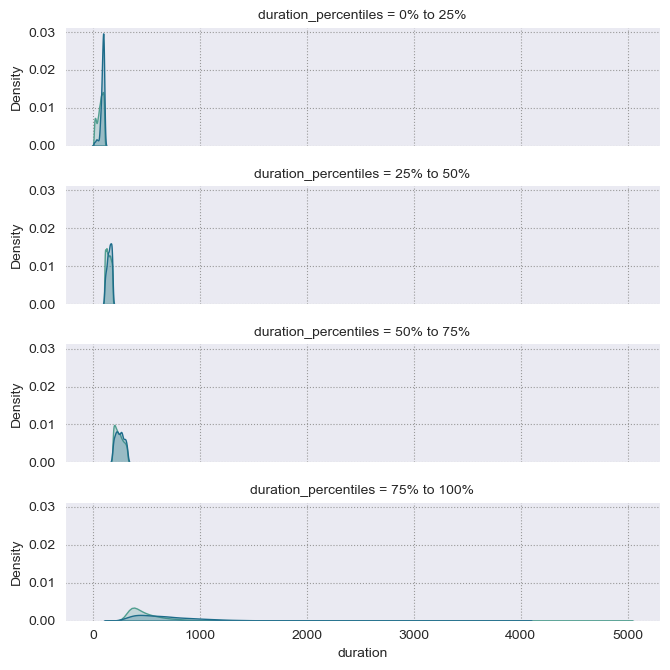

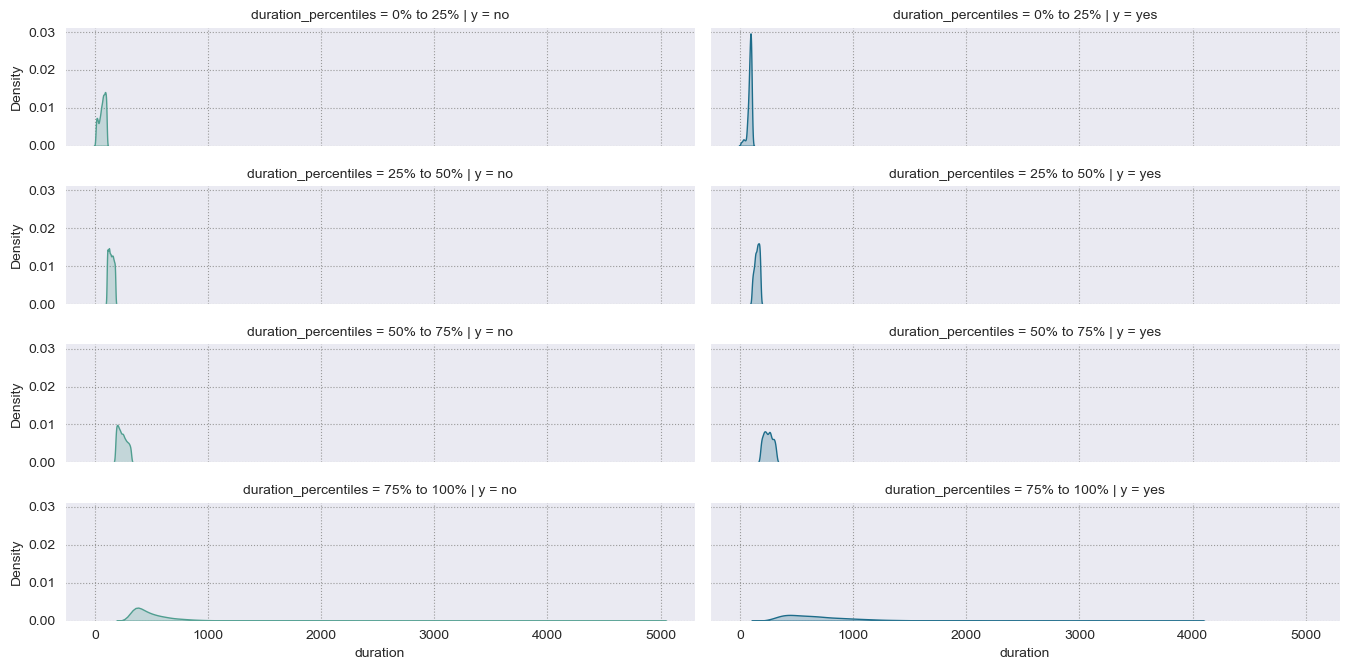

In [23]:
# print(ordered_duration_percentiles)
g2 = sns.FacetGrid(bank_df, row="duration_percentiles", row_order=labels,
                   height=1.7, aspect=4, hue='y', palette="crest")
g2.map(sns.kdeplot, "duration", fill=True)
plt.show(g2)

g2.savefig('../graphs/duration_distribution_percentages.png', dpi=400)

# print(ordered_duration_percentiles)
g3 = sns.FacetGrid(bank_df, col='y', row="duration_percentiles", row_order=labels,
                   height=1.7, aspect=4, hue='y', palette="crest")
g3.map(sns.kdeplot, "duration", fill=True)
plt.show(g3)

g3.savefig('../graphs/duration_distribution_percentages_split_y.png', dpi=400)


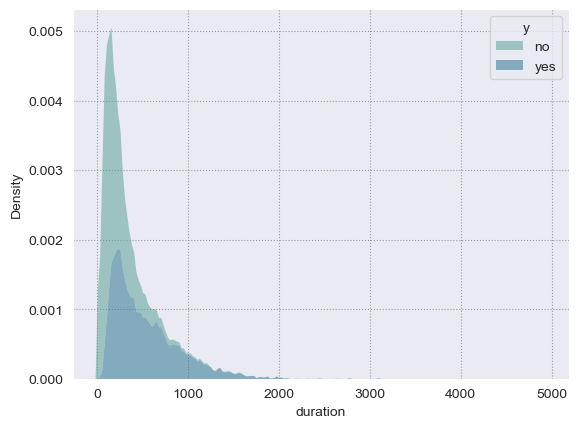

In [24]:
fig = sns.kdeplot(data=bank_df, x="duration", hue='y', bw_adjust=.2, multiple='stack', fill=True,
            common_norm=False, palette="crest", alpha=.5, linewidth=0)
plt.show(fig)


figure = fig.get_figure()
figure.savefig('../graphs/duration_distribution_per_y.png', dpi=400)


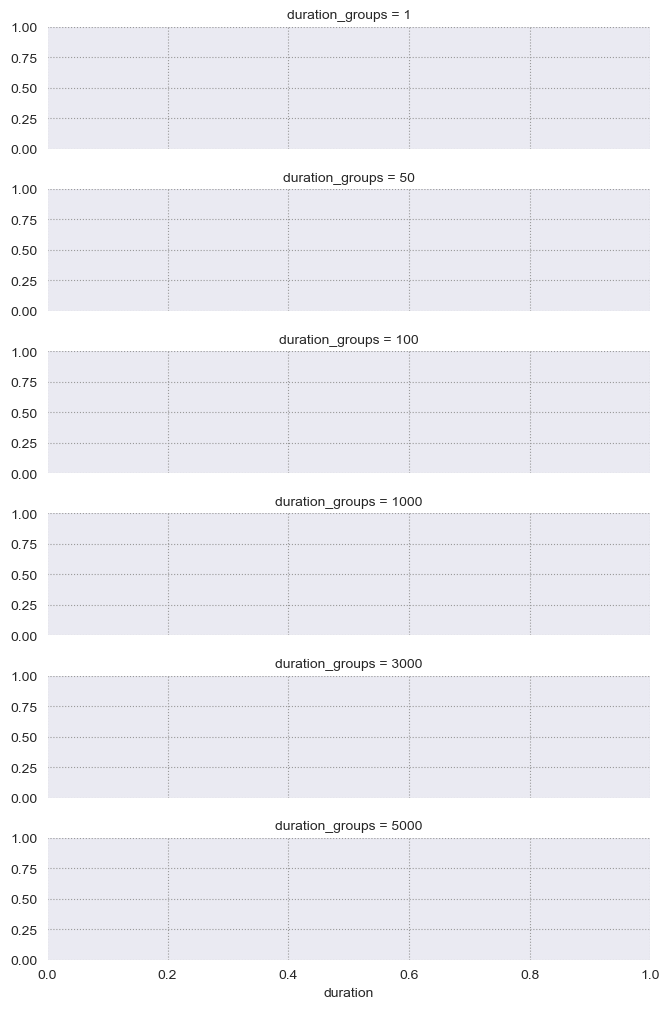

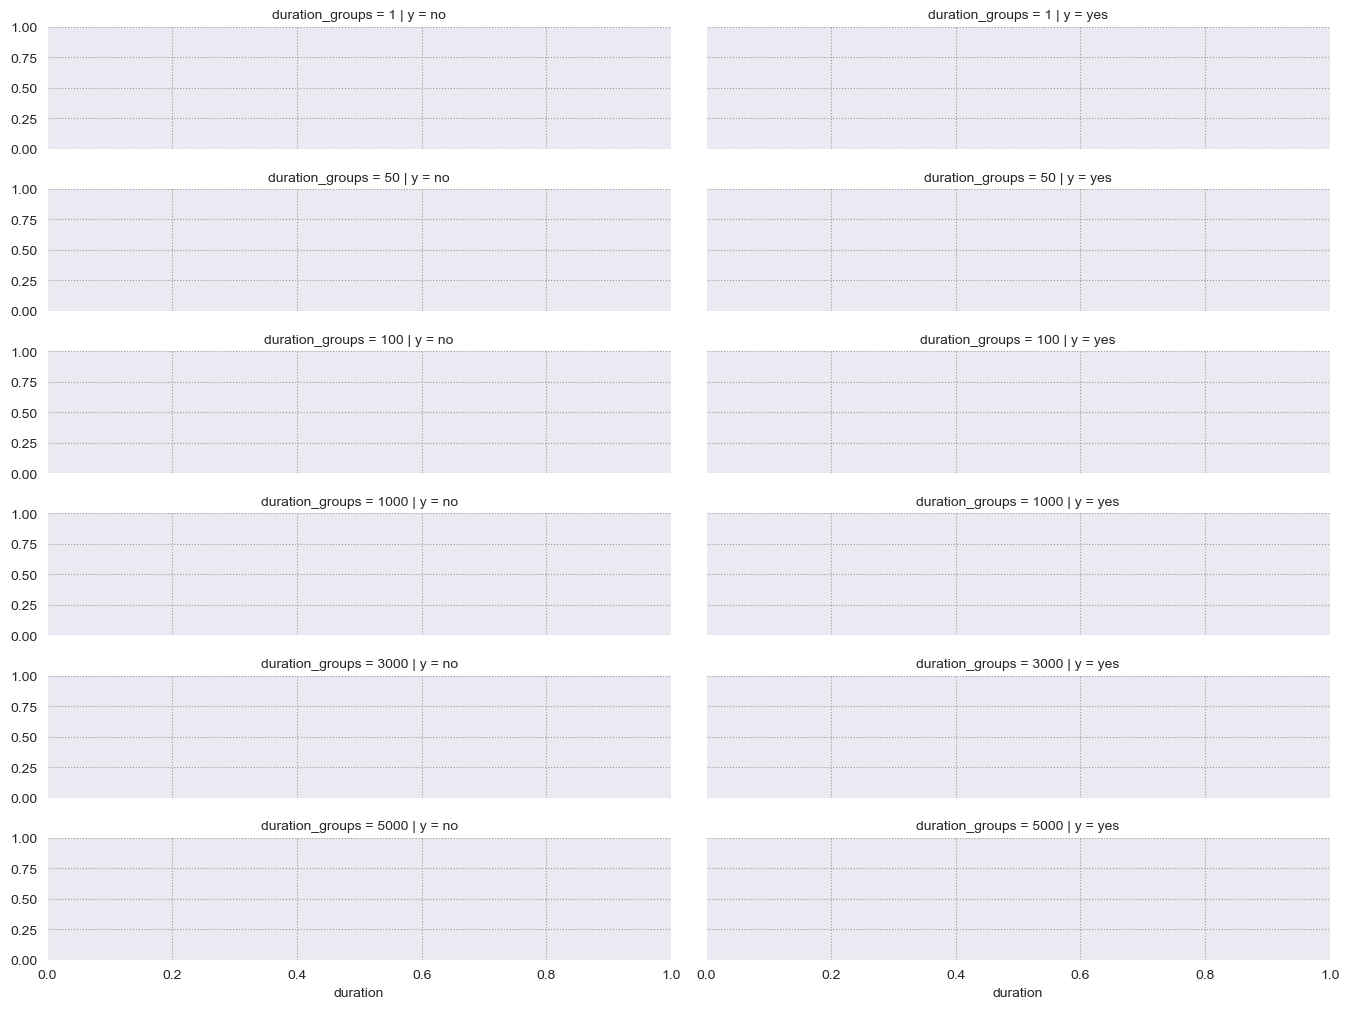

In [34]:
# print(ordered_duration_percentiles)
g4 = sns.FacetGrid(bank_df, row="duration_groups", row_order=durationBins,
                   height=1.7, aspect=4, hue='y', palette="crest")
g4.map(sns.kdeplot, "duration", fill=True)
plt.show(g4)

g4.savefig('../graphs/duration_distribution_bins.png', dpi=400)

# print(ordered_duration_percentiles)
g5 = sns.FacetGrid(bank_df, col='y', row="duration_groups", row_order=durationBins,
                   height=1.7, aspect=4, hue='y', palette="crest")
g5.map(sns.kdeplot, "duration", fill=True)
plt.show(g5)

g5.savefig('../graphs/duration_distribution_bins_split_y.png', dpi=400)
